# Data Modeling - Multicolinearity accounted for. 
training a model to fit the data, using the final dataset created in 1.3 feature engineering. 
- Oversampling techniques (not undersampling because the dataset is already small) - Using Finalized dataset.  
- Baseline model will be with Logistic regression
- Can try SVM, Naive bayes, SGDClassifier, KNN, Random Forest etc.
- See how the model performs. 

The data can be found here: https://www.kaggle.com/yasserh/breast-cancer-dataset

Documentation can be found here: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

You can also find the github repo here: https://github.com/brianl2/BrCancer_LHL_final

Next Notebook will be in regards to model tuning using RandomsearchCV and GridSearchCV

In [3]:
# import modules
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB # because Binomial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, roc_curve

In [4]:
X = pd.read_csv('data/final_data.csv') 
y = pd.read_csv('data/final_target.csv')

In [5]:
#Defining functions: 

# oversampling to fix imbalance we observed previously.
sm = SMOTE(random_state=42)

def oversample(X, y):
    '''function for oversampling with SMOTE'''
    print(f'before resample: {y.shape}')
    xres, yres = sm.fit_resample(X, y)
    print(f'after resample: {yres.shape}')
    # Show the imbalance fixed 
    colors = sns.color_palette('pastel')[0:5]
    data = yres.value_counts()
    labels =['Resampled Benign Tumors','Resampled Malignant Tumors']
    #create pie chart
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()
    return xres,yres

# Function to prep the data for modeling
def prep_data(X, y):
    '''Oversamples the data, and then splits the data 80:20, then reshapes y values into a np.array (x,)'''
    # oversample the data
    x,y = oversample(X, y)
    # Split the data (80:20) ratio because we don't have much data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42) 
    #Scale / normalize the data
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    #Reshape y for modeling
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    return X_train, X_test, y_train, y_test

# Function for Evaluating
def evaluate(y_true,y_pred, test):
    ''' Prints out all evaluation scores and plots a confusion matrix'''
    print(f'accuracy: {accuracy_score(y_true,y_pred)}' )
    print(f'precision: {precision_score(y_true,y_pred)}')
    print(f'recall:{recall_score(y_true,y_pred)}')
    print(f'f1 score: {f1_score(y_true,y_pred)}')
    print(f'ROC_AUC score: {roc_auc_score(y_true,y_pred)}')
    # Confusion Matrix plot
    cm = confusion_matrix(y_true,y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    xtick = ['Malignant Pred' , 'Benign Pred']
    ytick = ['Malignant True' , 'Benign True']
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = xtick , yticklabels = ytick).set_title(f'Confusion Matrix for {test}');
    
# function for plotting ROC curves
def plot_roc_curve(y_true, y_pred, test):
    '''Function for plotting ROC Curve for evaluation'''
    #ROC curve plot for model
    fpr1, tpr1, thresh1 = roc_curve(y_true, y_pred[:], pos_label=1)
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_true))]
    p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
    # Plotting
    plt.style.use('seaborn')
    # plot roc curves
    plt.plot(fpr1, tpr1, linestyle='--',color='orange', label= test) # test conducted
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label = 'baseline') # baseline
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show();
    
def save_evaluate(i, y_true, y_pred, df):
    '''Used to Save evaluations into an existing dataframe'''
    df.iloc[i]['Accuracy'] = round((accuracy_score(y_true,y_pred))*100,3)
    df.iloc[i]['Precision'] = round((precision_score(y_true,y_pred))*100,3)
    df.iloc[i]['Recall'] = round((recall_score(y_true,y_pred))*100,3)
    df.iloc[i]['f1_score'] = round((f1_score(y_true,y_pred))*100,3)
    df.iloc[i]['ROC_AUC_Score'] = round((roc_auc_score(y_true,y_pred))*100,3)
    return df 
    

before resample: (533, 1)
after resample: (686, 1)


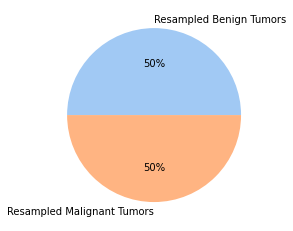

In [6]:
# Prepare the data with the function created. - We will be using this data for all the tests. (Without outliers and with reduced features)
X_train, X_test, y_train, y_test = prep_data(X,y)

In [7]:
# DataFrame To Save results 
column = ['Accuracy', 'Precision', 'Recall', 'f1_score', 'ROC_AUC_Score']
rows = ['LogReg', 'SVM', 'Naive Bayes', 'SGDClassifier', 'KNN', 'XGBoost', 'RFC']
results = pd.DataFrame(columns = column, index = rows)
results.head()

,Accuracy,Precision,Recall,f1_score,ROC_AUC_Score
LogReg,NaN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
SGDClassifier,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN


## Logistic Regression
Default Parameters:

In [8]:
# Logistic regression, with default parameters
LR_model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

accuracy: 0.9710144927536232
precision: 0.9710144927536232
recall:0.9710144927536232
f1 score: 0.9710144927536232
ROC_AUC score: 0.9710144927536232


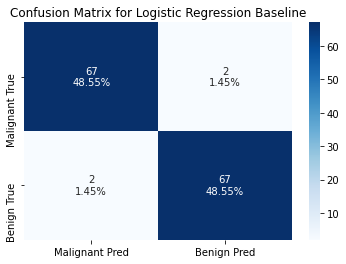

In [12]:
evaluate(y_test, y_pred, 'Logistic Regression Baseline')

In [8]:
results = save_evaluate(0, y_test, y_pred, results)

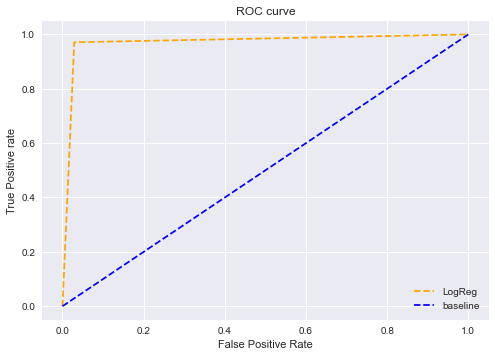

In [9]:
#plot ROC curve
plot_roc_curve(y_test, y_pred, 'LogReg')

## SVM Linear Kernel

accuracy: 0.9855072463768116
precision: 0.9855072463768116
recall:0.9855072463768116
f1 score: 0.9855072463768116
ROC_AUC score: 0.9855072463768115


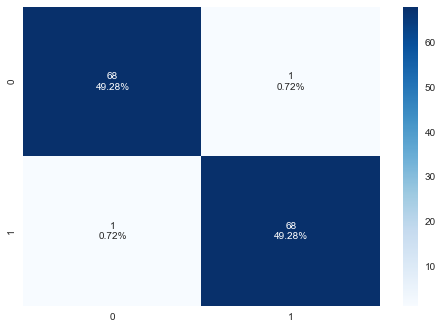

In [11]:
SVM_model = SVC(probability=True).fit(X_train, y_train)
y_pred2 = SVM_model.predict(X_test)
evaluate(y_test, y_pred2)
results = save_evaluate(1, y_test, y_pred2, results)

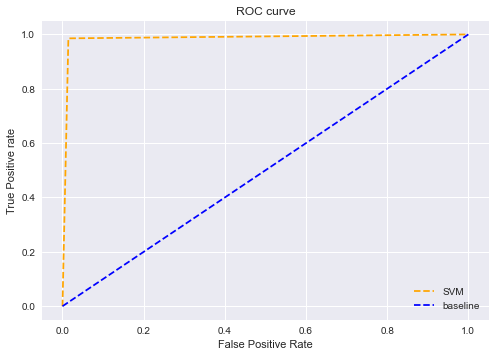

In [12]:
#plot ROC curve
plot_roc_curve(y_test, y_pred2, 'SVM')

## Naive Bayes

accuracy: 0.8985507246376812
precision: 0.8873239436619719
recall:0.9130434782608695
f1 score: 0.9
ROC_AUC score: 0.8985507246376812


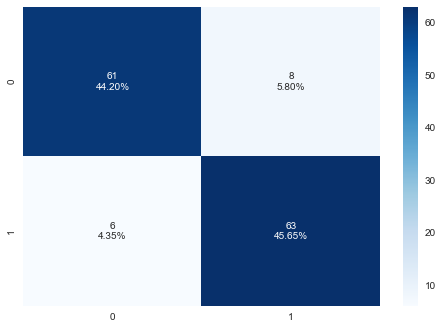

In [13]:
NB_model = BernoulliNB().fit(X_train, y_train)
y_pred3 = NB_model.predict(X_test)
evaluate(y_test, y_pred3)
results = save_evaluate(2, y_test, y_pred3, results)

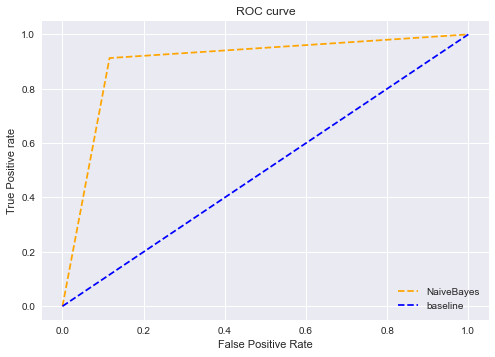

In [14]:
#plot ROC curve
plot_roc_curve(y_test, y_pred3, 'NaiveBayes')

## SGDClassifier

accuracy: 0.9565217391304348
precision: 0.9565217391304348
recall:0.9565217391304348
f1 score: 0.9565217391304348
ROC_AUC score: 0.9565217391304348


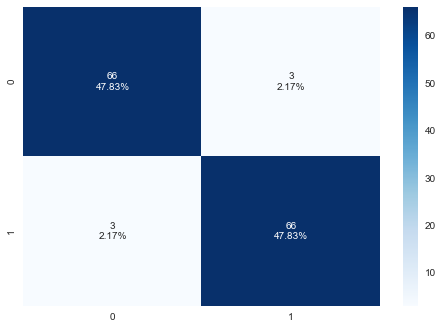

In [15]:
SGD_model = SGDClassifier().fit(X_train, y_train)
y_pred4 = SGD_model.predict(X_test)
evaluate(y_test, y_pred4)
results = save_evaluate(3, y_test, y_pred4, results)

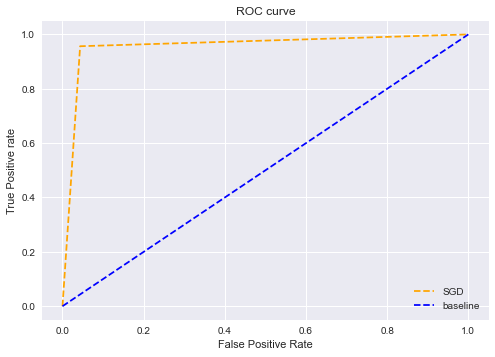

In [16]:
#plot ROC curve
plot_roc_curve(y_test, y_pred4, 'SGD')

## KNN

accuracy: 0.9637681159420289
precision: 0.9848484848484849
recall:0.9420289855072463
f1 score: 0.962962962962963
ROC_AUC score: 0.963768115942029


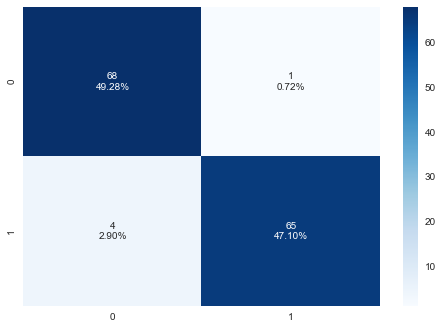

In [18]:
KNN_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred5 = KNN_model.predict(X_test)
evaluate(y_test, y_pred5)
results = save_evaluate(4, y_test, y_pred5, results)

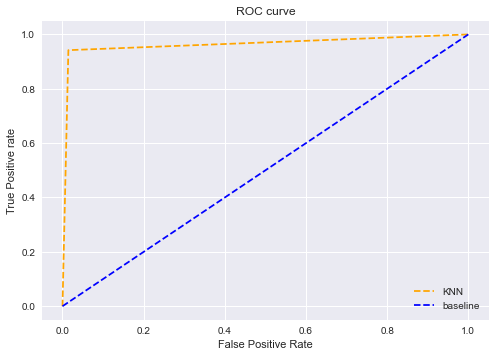

In [19]:
#plot ROC curve
plot_roc_curve(y_test, y_pred5, 'KNN')

## XGBoost

[14:03:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9492753623188406
precision: 0.9558823529411765
recall:0.9420289855072463
f1 score: 0.9489051094890512
ROC_AUC score: 0.9492753623188407


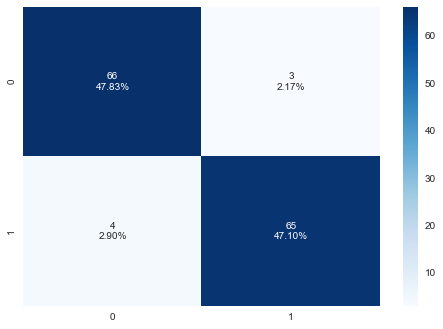

In [20]:
XGB_model = XGBClassifier(use_label_encoder=False).fit(X_train, y_train)
y_pred6 = XGB_model.predict(X_test)
evaluate(y_test, y_pred6)
results = save_evaluate(5, y_test, y_pred6, results)

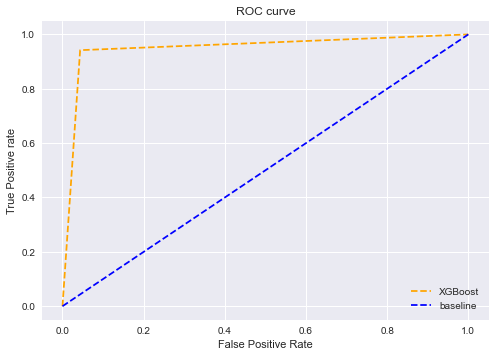

In [21]:
#plot ROC curve
plot_roc_curve(y_test, y_pred6, 'XGBoost')

## Random Forest Classifier

accuracy: 0.9420289855072463
precision: 0.9692307692307692
recall:0.9130434782608695
f1 score: 0.9402985074626865
ROC_AUC score: 0.9420289855072465


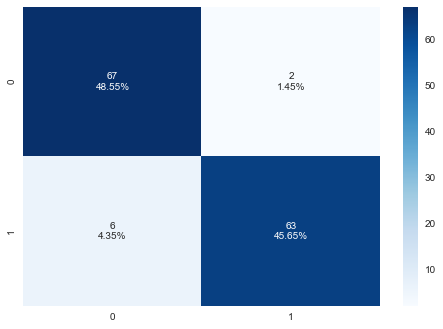

In [22]:
RFC_model = RandomForestClassifier().fit(X_train, y_train)
y_pred7 = RFC_model.predict(X_test)
evaluate(y_test, y_pred7)
results = save_evaluate(6, y_test, y_pred7, results)

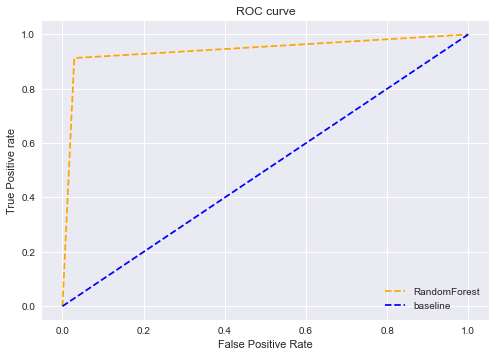

In [23]:
#plot ROC curve
plot_roc_curve(y_test, y_pred7, 'RandomForest')

In [24]:
# Comparing model scores:
results

,Accuracy,Precision,Recall,f1_score,ROC_AUC_Score
LogReg,97.101,97.101,97.101,97.101,97.101
SVM,98.551,98.551,98.551,98.551,98.551
Naive Bayes,89.855,88.732,91.304,90.0,89.855
SGDClassifier,95.652,95.652,95.652,95.652,95.652
KNN,96.377,98.485,94.203,96.296,96.377
XGBoost,94.928,95.588,94.203,94.891,94.928
RFC,94.203,96.923,91.304,94.03,94.203


From this, we see that SVM and Logistic regression performed the best. 
- Our baselines can be Logistic regression and SVM.
    - We can try to improve this with RandomSearchCV and Hyperparameter tuning for these two. 